# Introduction to intake-esgf

This guide is targetted at users who are new to obtaining [CMIP](https://www.wcrp-climate.org/wgcm-cmip) data from ESGF. While many people work hard to provide the community access in an intuitive fashion, ESGF remains a data source for researchers who have some prior understanding about the data they wish to find and how they are organized. This tutorial is meant to gently expose the uninitiated to key concepts and step you through your first searches using `intake-esgf`.

## Imports
Similar to intake-esm, we import, except we do not need to pass the path to the catalog itself.

In [1]:
from intake_esgf import ESGFCatalog

## Load the Catalog

First, import and instantiate the catalog.

In [2]:
cat = ESGFCatalog()
cat

Perform a search() to populate the catalog.

Then you can use the catalog to perform a free text search for any word that may be related to the variable for which you are searching.

## Which Variable Do We Need?

At the highest level, ESGF stores data in *projects* such as `CMIP5` and `CMIP6`. While there are some similarities between projects, the *control vocabulary*, that is the metadata used to identify unique datasets, varies. In this tutorial we will explain some of the CMIP6 vocabulary, which is the default project for `intake-esgf`.

Perhaps the most important search criteria to determine is the name of the variable you wish to use. `intake-esgf` has some functionality to assist.

In this case, we will search for `air temperature surface`.

In [3]:
cat.variable_info("air temperature surface")

,variable_long_name,cf_standard_name,variable_units
variable_id,,,
hfls,Surface Upward Latent Heat Flux,surface_upward_latent_heat_flux,W m-2
hfss,Surface Upward Sensible Heat Flux,surface_upward_sensible_heat_flux,W m-2
rlds,Surface Downwelling Longwave Radiation,surface_downwelling_longwave_flux_in_air,W m-2
rsds,Surface Downwelling Shortwave Radiation,surface_downwelling_shortwave_flux_in_air,W m-2
sfcWind,Near-Surface Wind Speed,wind_speed,m s-1
ta,Air Temperature,air_temperature,K
tas,Near-Surface Air Temperature,air_temperature,K
tasmax,Daily Maximum Near-Surface Air Temperature,air_temperature,K
tasmin,Daily Minimum Near-Surface Air Temperature,air_temperature,K


This function returns a pandas dataframe which lists the name of several variables along with their units and standard names. From a perusal of this list, it appears that `tas` is the variable we want for this search. The dataframe index also shows us that the name of the control vocabulary is `variable_id`.

## Controlled Vocabulary

While we could now perform a search for `variable_id=tas`, this search will take quite some time. `intake-esgf` currently works better if we give it a better idea of what we wish to find. Simply put, we recommend constraining the search.

One of the more useful search facets is the `experiment_id`, a unique identifier corresponding to the experiment. As part of the planning phase of the CMIP process, groups of researchers write papers detailing the specific method that a model is to be run to be included in an experiment. This allows modeling centers to follow the protocol if they wish to be part of the experiment. You can [browse](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html) the experiments to see the indentifiers and some basic information.

One commonly used experiment is `historical`, where models are run using reconstructions of the historical earth state from 1850 until 2015. We will use this in our example search.

In [4]:
cat.search(variable_id="tas",experiment_id="historical")

   Searching indices:   0%|          |0/2 [       ?index/s]

Summary information for 1687 results:
mip_era                                                     [CMIP6]
activity_drs                                                 [CMIP]
institution_id    [IPSL, NASA-GISS, NCAR, MPI-M, MRI, CNRM-CERFA...
source_id         [IPSL-CM6A-LR, GISS-E2-1-H, CESM2, GISS-E2-1-G...
experiment_id                                          [historical]
member_id         [r9i1p1f1, r7i1p1f1, r4i1p1f1, r27i1p1f1, r5i1...
table_id          [ImonGre, ImonAnt, Amon, day, 3hr, 6hrPlevPt, ...
variable_id                                                   [tas]
grid_label                             [grg, gra, gr, gn, gr1, gr2]
dtype: object

### Understanding the Returned Search
This will populate an underlying pandas dataframe with the search results. The columns of that dataframe and unique values are presented . This exposes more of the control vocabulary for CMIP6. We have already explored `variable_id` and `experiment_id`. Now we explain more of the control vocabulary emphasizing what we find to be the more useful facets.
- `source_id` - The identifier of the model. We use the term *source* instead of *model* in an attempt to make the control vocabulary more general and in the future unify vocabularies among projects. Each model or model version will have a unique string identifying which model and/or configuration was run, which can be [browsed](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_source_id.html).
- `member_id` - The label for the variant of the model run (also known as `variant_label`). The precise meaning of these labels is specific to each model group. For CMIP6 these take the form `r...i...p...f...` where integers after each character reflect a separate run. Usually (but not with all models) the main result will be `r1i1p1f1`.
  - `r` stands for the *realization*. Models can be run with small pertubations of the initial conditions to produce an ensemble. Model runs with the same `r` number started with the same initial conditions.
  - `i` stands for the *initialization*. Models use different methods to spin up their states into quasi-equilibrium. This integer reflects the method that was used by the model.
  - `p` stands for the *physics*. Modern models have many configuration options and while most submit results in a single configuration, this designation provides a method to distinguish among them if desired.
  - `f` stands for the *forcing*. When multiple methods for forcing an experiment are possible, this label distinguishes among them.
- `table_id` - Variables are organized into what CMIP refers to as tables. This tends to be a juxtaposition of a problem realm (`A` for atmosphere, `O` for ocean) along with time frequency (`mon` for month, `day` for day). Note that a variable can exist in several tables. In our search we see that there is `day` temperature data as well as monthly `Amon`.

## Downloading Data

We will refine our search to select a single model `CanESM5`, variant `r1i1p1f1`, and table `Amon`.

In [5]:
cat.search(
    variable_id="tas",
    experiment_id="historical",
    source_id="CanESM5",
    member_id="r1i1p1f1",
    table_id="Amon"
)

   Searching indices:   0%|          |0/2 [       ?index/s]

Summary information for 1 results:
mip_era                [CMIP6]
activity_drs            [CMIP]
institution_id         [CCCma]
source_id            [CanESM5]
experiment_id     [historical]
member_id           [r1i1p1f1]
table_id                [Amon]
variable_id              [tas]
grid_label                [gn]
dtype: object

Once your search has been sufficiently narrowed, you may download into a dictionary of [xarray](https://docs.xarray.dev/en/stable/) datasets, similar to intake-esm.

In [7]:
dset_dict = cat.to_dataset_dict()

Get file information:   0%|          |0/2 [       ?index/s]

Adding cell measures:   0%|          |0/1 [     ?dataset/s]

Note that you do not need to explicitly search for cell measures such as `areacella`. These will be included [automatically](measures). The files are downloaded locally to a cache directory which mirrors the directory structure of the remote storate. So while the above code is how you download data, it is also how you load it into memory for your analysis scripts. There is no need to handle files in your working directory or write complicated code to load them into memory.

## Plotting
Note that you do not need to explicitly search for cell measures such as `areacella`. These will be included [automatically](measures). The files are downloaded locally to a cache directory which mirrors the directory structure of the remote storate. So while the above code is how you download data, it is also how you load it into memory for your analysis scripts. There is no need to handle files in your working directory or write complicated code to load them into memory.

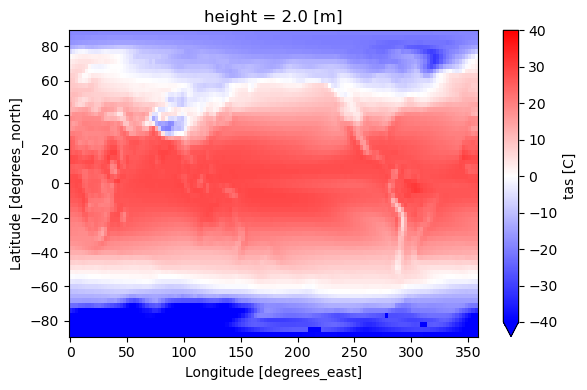

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ds = dsd["tas"]["tas"].mean(dim="time") - 273.15  # to [C]
ds.plot(ax=ax, cmap="bwr", vmin=-40, vmax=40, cbar_kwargs={"label": "tas [C]"})

## Where is my data?
You might be curious where the actual datasets are saved to; you can extract just the paths to the data using the following:

In [11]:
paths = cat.to_path_dict()
print(paths)

Get file information:   0%|          |0/2 [       ?index/s]

{'tas': [PosixPath('/Users/mgrover/.esgf/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')]}


### Changing the configuration
You can reconfigure or change where intake-esgf looks for data using the configuration settings.

In [13]:
print(intake_esgf.conf)

additional_df_cols: []
break_on_error: true
download_db: ~/.config/intake-esgf/download.db
esg_dataroot:
- /p/css03/esgf_publish
- /eagle/projects/ESGF2/esg_dataroot
- /global/cfs/projectdirs/m3522/cmip6/
globus_indices:
  anl-dev: true
  ornl-dev: true
local_cache:
- ~/.esgf/
logfile: ~/.config/intake-esgf/esgf.log
num_threads: 6
solr_indices:
  esg-dn1.nsc.liu.se: false
  esgf-data.dkrz.de: false
  esgf-node.ipsl.upmc.fr: false
  esgf-node.llnl.gov: false
  esgf-node.ornl.gov: false
  esgf.ceda.ac.uk: false
  esgf.nci.org.au: false



for example, we could change the local cache to be the temporary directory:

In [14]:
intake_esgf.conf.set(local_cache="~/tmp")
print(intake_esgf.conf['local_cache'])

['~/tmp']
